In [17]:

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as st
import numpy as np
import importlib as imp
import lower as low
import param_estim as pe
imp.reload(low)
imp.reload(plt)
imp.reload(pe)
lows = low.Tools()
ems = low.EM()
import warnings
import full_analysis as fa
imp.reload(fa)
warnings.filterwarnings("ignore")

In [4]:
#simulation to investigate effects of LR on mu and beta

#generate normal distribution, log-transform, fit LR with different settings (one extends too much to the left)


def get_linreg(sample, survival, alpha):
    
    th = int(alpha*len(sample))
    tail_y = np.log(1-survival[-th:-10])
    tail_x = sample[-th:-10]
    lin_reg = st.linregress(tail_x, tail_y)
    #print(lin_reg)
    return lin_reg, tail_x, tail_y

def get_tevs(lr, sample, beta, mu):
    
    evs = np.exp(lr.slope*sample + lr.intercept)
    #tevs = -beta*np.log(evs/np.exp(mu/beta))
    return evs


def get_expon(sample, alpha):
    
    th = int(alpha*len(sample))
    subsample = sorted(sample)[-th:-10]
    mu = min(subsample)
    lambda_0 = (len(subsample)-1)/(np.sum(subsample-mu))
    pvs = (1 - st.expon.cdf(subsample[-10:][::-1], loc=mu, scale=1/lambda_0))
    return pvs

    
#get e-values, generate TEVs, plot distributions, estimate mu and beta

In [8]:

N=1000
"""
tevs = np.zeros((N,10))
trues = np.zeros((N,10))
for i in range(N):
    
    sample = np.array(sorted(st.norm.rvs(0.5, 1, 1000)))
    survival = (np.arange(len(sample))+1)/len(sample)
    lr, tail_x, tail_y = get_linreg(sample, survival, 0.05)
    tv = get_tevs(lr, sample[-10:][::-1], 0.02, 0.1)
    tevs[i,:] = tv
    trues[i,:] = (1-st.norm.cdf(sample[-10:][::-1], 0.5, 1))

    """
    
tevs2 = np.zeros((N,10))  
trues2 = np.zeros((N,10)) 
expons = np.zeros((N,10))
for i in range(N):
    np.random.seed()
    sample = np.array(sorted(st.norm.rvs(0.5, 1, 10000)))
    survival = (np.arange(len(sample))+1)/len(sample)
    lr, tail_x, tail_y = get_linreg(sample, survival, 0.05)
    tv = get_tevs(lr, sample[-10:][::-1], 0.02, 0.1)
    tevs2[i,:] = tv
    trues2[i,:] = (1-st.norm.cdf(sample[-10:][::-1], 0.5, 1))
    expons[i,:] = get_expon(sample, 0.05)

In [9]:
df5 = pd.DataFrame()
t1 = []
t2 = []
t3 = []
texpon = []
no = 10000
for dx in np.arange(10):
    t1+= list(no*trues2[:,dx])
    t2 += list(no*tevs2[:,dx])
    texpon += list(no*expons[:,dx])
    t3 += list(dx*np.ones(len(trues2[:,dx]))+1)

df5['true EV'] = t1
df5['estimated EV'] = t2
df5['hit'] = t3
df5['hit'] = df5['hit'].astype('int')
df5['relative bias'] = (np.array(t2) - np.array(t1))/np.array(t1)
df5['TEV'] = -0.02*np.log(df5['estimated EV']/1000)
df5['expon'] = texpon

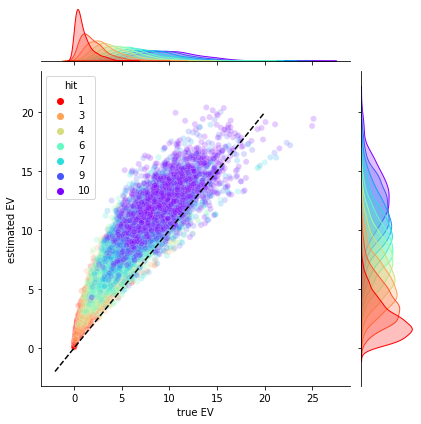

In [11]:
#ax.plot([0, 25], [0, 25])

plot = sns.jointplot(data=df5, x="true EV", y="estimated EV", hue="hit", palette='rainbow_r', alpha=0.2)
plot.ax_joint.plot([-2, 20], [-2, 20], color='k', linestyle='--')
#plt.savefig("./graphs/scatters_cutoff0005_10000.png", dpi=400)
#sns.jointplot(data=df4, x="true", y="estim", kind='kde')
#sns.kdeplot(data=df3, x="true", y="estim",  fill=0)


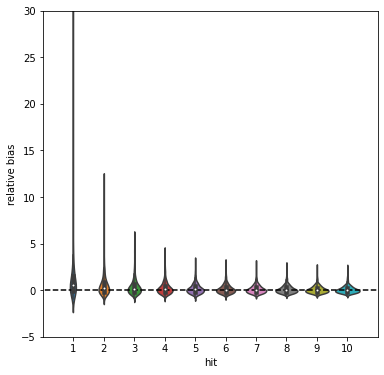

In [303]:
fig, ax = plt.subplots(figsize=(6, 6))
sns.violinplot(data=df5, x="hit", y="relative bias", ax=ax)
ax.hlines(xmin=-2, xmax=11, y=0, color='k', linestyle='--')
ax.set_xlim(-1, 10)
ax.set_ylim(-5, 30)
plt.savefig("./graphs/violin_seaborn_cutoff0005_10000.png", dpi=400)

In [14]:
mus = []
betas = []

for i in range(10):
    mu1, b1 = lows.mle_new(df5[df5.hit == i+1]['TEV'].to_numpy(), i)
    mus.append(mu1)
    betas.append(b1)

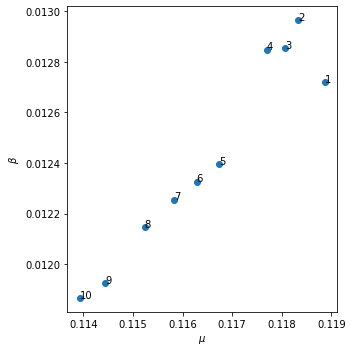

In [15]:
fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(mus, betas)
annotations = np.arange(10) +1
for i, label in enumerate(annotations):
    plt.annotate(label, (mus[i], betas[i]))
ax.set_ylabel(r"$\beta$")
ax.set_xlabel(r"$\mu$")
fig.tight_layout()
#fig.savefig(f"./graphs/mubeta_LR_simulation_cutoff005.png", dpi=500)


-0.9803377256132529


Text(2.0, -2, "Pearson's r: -0.98034")

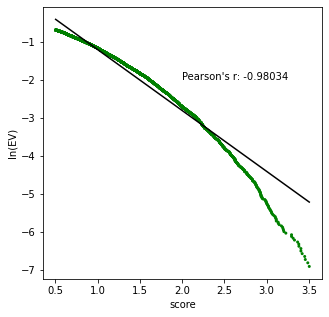

In [16]:
cut = 0.5
sample = np.array(sorted(st.norm.rvs(0.5, 1, 10000)))
survival = (np.arange(len(sample))+1)/len(sample)
lr, tail_x, tail_y = get_linreg(sample, survival, cut)
tv = get_tevs(lr, sample[-10:][::-1], 0.02, 0.05)
tevs2[i,:] = tv
print(lr.rvalue)
fig, ax = plt.subplots(figsize=(5,5))
sns.scatterplot(x=tail_x, y=tail_y, color='green', marker='.', edgecolor='none')
plt.xlabel("score")
plt.ylabel("ln(EV)")
#ax.scatter(tail_x, tail_y, marker='x', c='g')
ax.plot([min(tail_x), max(tail_x)], [min(tail_x)*lr.slope+lr.intercept,max(tail_x)*lr.slope+lr.intercept], c='k')
ax.text(x=2., y=-2, s=f"Pearson's r: {lr.rvalue:.5f}" )
#fig.savefig("./graphs/LR_cutoff05_10000.png", dpi=400)
